In [20]:
import netket as nk
import jax
from netket.operator.spin import sigmax,sigmaz, sigmap, sigmam
from scipy.sparse.linalg import eigsh
import numpy as np
import matplotlib.pyplot as plt
import time

def ABC(L, a):
    B = {}
    A = {a}
    C = {}
    for i in range (a+1, L-1):
        B[i] = [i]
    for i in B:
        if i!=a+1:
            B[i]+=B[i-1]
            B[i].sort()
    for i in B:
        C[i] = set(range(L))-set(B[i])-A
    return A, B, C

def ABC_periodic(L):
    B = {}
    A = {}
    C = {}
    for i in range (int(L/2)):
        A[i] = [i]
        C[i] = [i+int(L/2)]

    for i in A:
        if i!=0:
            A[i]+=A[i-1]
            C[i]+=C[i-1]
            A[i].sort()
            C[i].sort()
        B[i] = list(set(range(L))-set(A[i])-set(C[i]))
    return A, B, C

def cmi_(prob_exact, L):
    A,B,C = ABC(L, 0)
    cmi = []
    p_ab = prob_exact.sum(axis=tuple(set(range(L))-A))+1e-30
    p_bc = prob_exact.sum(axis=tuple(A))+1e-30
    cmi.append(-np.sum(p_ab*np.log(p_ab))-np.sum(p_bc*np.log(p_bc))+np.sum(prob_exact*np.log(prob_exact+1e-30)))
    for i in B:
        tmp = 0
        p_ab = prob_exact.sum(axis=tuple(C[i]))
        tmp += np.sum(p_ab*np.log(p_ab))+1e-30
        p_bc = prob_exact.sum(axis=tuple(A))
        tmp += np.sum(p_bc*np.log(p_bc))+1e-30
        tmp -= np.sum(prob_exact*np.log(prob_exact+1e-30))
        p_b = prob_exact.sum(axis=tuple(C[i].union(A)))+1e-30
        tmp -= np.sum(p_b*np.log(p_b))
        cmi.append(-tmp)
    return np.array(cmi)

def cmi_periodic(prob_exact, L):
    A,B,C = ABC_periodic(L)
    cmi = []
    for i in B:
        tmp = 0
        p_ab = prob_exact.sum(axis=tuple(C[i]))
        tmp += np.sum(p_ab*np.log(p_ab))+1e-30
        p_bc = prob_exact.sum(axis=tuple(A[i]))
        tmp += np.sum(p_bc*np.log(p_bc))+1e-30
        tmp -= np.sum(prob_exact*np.log(prob_exact+1e-30))
        if i != int(L/2)-1:
            p_b = prob_exact.sum(axis=tuple(list(set(C[i]).union(set(A[i])))))+1e-30
            tmp -= np.sum(p_b*np.log(p_b))
        cmi.append(-tmp)
    return cmi

def cmi_traceout(prob_exact, L):
    I = []
    cmi = [[] for i in range(L-5)]
    for i in range(L-5):
        if i!=0:
            I.append(i)
        A,B,C = ABC(L, i)
        p_ab = prob_exact.sum(axis=tuple(set(range(L))-A))+1e-30
        p_bc = prob_exact.sum(axis=tuple(A.union(set(I))))+1e-30
        prob_exact_ = prob_exact.sum(axis=tuple(set(I)))+1e-30
        cmi[i].append(-np.sum(p_ab*np.log(p_ab))-np.sum(p_bc*np.log(p_bc))+np.sum(prob_exact_*np.log(prob_exact_+1e-30)))
        for j in B:
            tmp = 0
            p_ab = prob_exact.sum(axis=tuple(C[j].union(set(I))))
            tmp += np.sum(p_ab*np.log(p_ab))
            p_bc = prob_exact.sum(axis=tuple(A.union(set(I))))
            tmp += np.sum(p_bc*np.log(p_bc))
            tmp -= np.sum(prob_exact_*np.log(prob_exact_+1e-30))
            p_b = prob_exact.sum(axis=tuple(C[j].union(A).union(set(I))))
            tmp -= np.sum(p_b*np.log(p_b))
            cmi[i].append(-tmp)
    return np.array(cmi)

def cmi_traceout_periodic(prob_exact, L):
    I = []
    cmi = [[] for i in range(L-5)]
    for i in range(L-5):
        if i!=0:
            I.append(i)
        A,B,C = ABC(L, i)
        p_ab = prob_exact.sum(axis=tuple(set(range(L))-A))+1e-30
        p_bc = prob_exact.sum(axis=tuple(A.union(set(I))))+1e-30
        prob_exact_ = prob_exact.sum(axis=tuple(set(I)))+1e-30
        cmi[i].append(-np.sum(p_ab*np.log(p_ab))-np.sum(p_bc*np.log(p_bc))+np.sum(prob_exact_*np.log(prob_exact_+1e-30)))
        for j in B:
            tmp = 0
            p_ab = prob_exact.sum(axis=tuple(C[j].union(set(I))))
            tmp += np.sum(p_ab*np.log(p_ab))
            p_bc = prob_exact.sum(axis=tuple(A.union(set(I))))
            tmp += np.sum(p_bc*np.log(p_bc))
            tmp -= np.sum(prob_exact_*np.log(prob_exact_+1e-30))
            p_b = prob_exact.sum(axis=tuple(C[j].union(A).union(set(I))))
            tmp -= np.sum(p_b*np.log(p_b))
            cmi[i].append(-tmp)
    return np.array(cmi)

def spin_correlation_all(prob_exact, L):
    corr = [[] for i in range(L)]
    mean_corr = [[] for i in range(L)]
    var_corr = [[] for i in range(L)]
    for i in range(L):
        for j in range(i+1, L):
            p_spin = prob_exact.sum(axis=tuple(set(range(L))-set([i, j])))+1e-30
            p_spin0 = p_spin.sum(axis=0)
            p_spin1 = p_spin.sum(axis=1)
            cor = (p_spin[0, 0]+p_spin[1, 1]-p_spin[0, 1]-p_spin[1, 0])-(p_spin0[0]-p_spin0[1])*(p_spin1[0]-p_spin1[1])
            corr[np.abs(j-i)].append(cor)
        p_spin = prob_exact.sum(axis=tuple(set(range(L))-set([i])))+1e-30
        cor = (p_spin**2).sum()-(p_spin[0]-p_spin[1])**2
        corr[0].append(cor)
    for i in range(len(corr)):
        mean_corr[i] = np.array(corr[i]).mean()
        var_corr[i] = np.array(corr[i]).var()
    return np.abs(mean_corr), np.array(var_corr)

def spin_correlation_periodic(prob_exact, L):
    corr = [[] for i in range(int(L/2)+1)]
    mean_corr = [[] for i in range(int(L/2)+1)]

    for i in range(1, int(L/2)+1):
        p_spin = prob_exact.sum(axis=tuple(set(range(L))-set([0, i])))+1e-30
        p_spin0 = p_spin.sum(axis=0)
        p_spin1 = p_spin.sum(axis=1)
        cor = (p_spin[0, 0]+p_spin[1, 1]-p_spin[0, 1]-p_spin[1, 0])-(p_spin0[0]-p_spin0[1])*(p_spin1[0]-p_spin1[1])
        corr[np.abs(i)].append(cor)
        p_spin = prob_exact.sum(axis=tuple(set(range(L))-set([0])))+1e-30
        cor = (p_spin**2).sum()-(p_spin[0]-p_spin[1])**2
        corr[0].append(cor)
    for i in range(len(corr)):
        mean_corr[i] = np.array(corr[i]).mean()
    return np.abs(mean_corr)
def count_diff_ones_zeros(n):
    # Generating all combinations from 0^n to 1^n
    combinations = np.array([np.binary_repr(i, width=n) for i in range(2**n)])

    # Counting the difference between the number of 1s and 0s in each combination
    diff_counts = np.array([combination.count('1') - combination.count('0') for combination in combinations])

    return diff_counts
L = 16
hi = nk.hilbert.Spin(s=1 / 2, N=L)
Gamma = -1
delta = [0.5, 0.8, 0.95, 1.0, 1.05, 1.2, 1.5, 2.0]
periodic = False
for z_int in delta:
    H = sum([2*(sigmap(hi,i)*sigmam(hi,(i+1))+sigmam(hi,i)*sigmap(hi,(i+1))) + z_int*sigmaz(hi, i)*sigmaz(hi, (i+1))   for i in range(L-1)])
    if periodic:
        H += 2*(sigmap(hi,0)*sigmam(hi,L-1)+sigmam(hi,0)*sigmap(hi,L-1))+z_int*sigmaz(hi,0)*sigmaz(hi,L-1)
    sp_h = H.to_sparse()
    eig_vals, eig_vecs = eigsh(sp_h, k=2, which="SA")
    print("eigenvalues with scipy sparse:", eig_vals)
    probs_exact =  np.abs(eig_vecs[:, 0]) ** 2
    mag = np.sum(probs_exact*np.array(count_diff_ones_zeros(L)))
    shape = (2,) * (L)
    probs_exact = probs_exact.reshape(*shape)

    if (periodic == False):
        cmi = cmi_(probs_exact, L)
        mean_corr, var_corr = spin_correlation_all(probs_exact, L)

    else:
        cmi = cmi_periodic(probs_exact, L)
        mean_corr = spin_correlation_periodic(probs_exact, L)
    cmi_all = cmi_traceout(probs_exact, L)
    np.save("result/1DXXZ/cmi_1DXXZ_L"+str(L)+"_zint_"+str(z_int)+"periodic_"+str(periodic)+".npy", cmi)
    np.save("result/1DXXZ/mean_corr_1DXXZ_L"+str(L)+"_zint_"+str(z_int)+"periodic_"+str(periodic)+".npy", mean_corr)
    if periodic == False:
        np.save("result/1DXXZ/var_corr_1DXXZ_L"+str(L)+"_zint_"+str(z_int)+"periodic_"+str(periodic)+".npy", var_corr)
    np.save("result/1DXXZ/cmi_traceout_1DXXZ_L"+str(L)+"_zint_"+str(z_int)+"periodic_"+str(periodic)+".npy", cmi_all)
    np.save("result/1DXXZ/mag_1DXXZ_L"+str(L)+"_zint_"+str(z_int)+"periodic_"+str(periodic)+".npy", mag)
    np.save("result/1DXXZ/gap_1DXXZ_L"+str(L)+"_zint_"+str(z_int)+"periodic_"+str(periodic)+".npy", np.array(eig_vals[1]-eig_vals[0]))


eigenvalues with scipy sparse: [-23.34155471 -22.73266192]


C:\Users\Administrator\AppData\Local\Temp\ipykernel_27344\1639573391.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(cmi)


eigenvalues with scipy sparse: [-25.85172296 -25.08565218]
eigenvalues with scipy sparse: [-27.18915  -26.340374]
eigenvalues with scipy sparse: [-27.64694858 -26.76984172]
eigenvalues with scipy sparse: [-28.11070981 -27.24794704]
eigenvalues with scipy sparse: [-29.53764836 -28.73030692]
eigenvalues with scipy sparse: [-32.55146881 -31.89601866]
eigenvalues with scipy sparse: [-38.04381192 -37.66599499]


In [21]:
import numpy as np
import matplotlib.pyplot as plt
# Dictionary to store the loaded array

cmi = {}
mean_corr= {}
var_corr = {}
gap = {}
cmi_traceout = {}
mag = {}
# Looping through the values and loading each file
for b in delta:
    filename = f"result/1DXXZ/cmi_1DXXZ_L{L}_zint_{b}periodic_{periodic}.npy"
    cmi[b] = np.load(filename)
    if periodic == True:
        cmi[b] = np.flip(cmi[b])
    filename = f"result/1DXXZ/mean_corr_1DXXZ_L{L}_zint_{b}periodic_{periodic}.npy"
    mean_corr[b] = np.load(filename)
    if periodic == False:
        filename = f"result/1DXXZ/var_corr_1DXXZ_L{L}_zint_{b}periodic_{periodic}.npy"
        var_corr[b] = np.load(filename)
    filename = f"result/1DXXZ/gap_1DXXZ_L{L}_zint_{b}periodic_{periodic}.npy"
    gap[b] = np.load(filename)
    filename = f"result/1DXXZ/cmi_traceout_1DXXZ_L{L}_zint_{b}periodic_{periodic}.npy"
    cmi_traceout[b] = np.load(filename, allow_pickle=True)
    filename = f"result/1DXXZ/mag_1DXXZ_L{L}_zint_{b}periodic_{periodic}.npy"
    mag[b] = np.load(filename)


In [22]:
mean_corr

{0.5: array([0.5       , 0.53289144, 0.1143247 , 0.1132378 , 0.04805179,
        0.05558499, 0.02843635, 0.03571418, 0.01950227, 0.02625982,
        0.01438554, 0.0210534 , 0.0109244 , 0.01837866, 0.00816155,
        0.02133559]),
 0.8: array([0.5       , 0.58235737, 0.18984019, 0.16562238, 0.09514157,
        0.09172109, 0.0609488 , 0.06202129, 0.04335395, 0.0461579 ,
        0.03237188, 0.03639534, 0.02447168, 0.03034502, 0.01794705,
        0.03210108]),
 0.95: array([0.5       , 0.60641575, 0.22939617, 0.19694721, 0.12479304,
        0.1163345 , 0.08365518, 0.08142756, 0.06112946, 0.06162382,
        0.04636082, 0.04874793, 0.03531157, 0.04021055, 0.02592626,
        0.04109845]),
 1.0: array([0.5       , 0.61437664, 0.24284906, 0.20813423, 0.13563855,
        0.12561736, 0.09235045, 0.08902225, 0.06815759, 0.06783883,
        0.05202286, 0.05380854, 0.03977707, 0.04430695, 0.02925811,
        0.04485524]),
 1.05: array([0.5       , 0.62231694, 0.25643631, 0.21969052, 0.14697548,
 

In [23]:
cmi_length = []
err_cmi_length =[]
corre_length = []
err_corre_length = []
cmi_length_traceout = [[] for i in range (len(delta))]
err_cmi_length_traceout = [[] for i in range (len(delta))]
for i in delta:
    cmi[i] = np.abs(cmi[i])
    for j in range(len(cmi_traceout[i])):
        cmi_traceout[i][j] = np.abs(np.array(cmi_traceout[i][j]))
for i in delta:
    df = len(cmi[i])-2
    (cmi_len, b1), residuals, _, _, _ = np.polyfit(np.arange(len(cmi[i])), -np.log(cmi[i]), 1, full=True)
    mean_x = np.mean(np.arange(len(cmi[i])))
    err = np.sqrt(residuals / df) / np.sqrt(np.sum((np.arange(len(cmi[i])) - mean_x)**2))
    cmi_length.append(cmi_len)
    err_cmi_length.append(err)

    (corr_len, b2), residuals, _, _, _ = np.polyfit(np.arange(len(mean_corr[i])), -np.log(np.abs(mean_corr[i])), 1, full=True)
    mean_x = np.mean(np.arange(len(mean_corr[i])))
    err = np.sqrt(residuals / df) / np.sqrt(np.sum((np.arange(len(mean_corr[i])) - mean_x)**2))
    corre_length.append(corr_len)
    err_corre_length.append(err)

    for j in range(len(cmi_traceout[i])):
        df = len(cmi_traceout[i][j])-2
        (cmi_len, b1), residuals, _, _, _ = np.polyfit(np.arange(len(cmi_traceout[i][j])), -np.log(cmi_traceout[i][j]+1e-32), 1, full=True)
        mean_x = np.mean(np.arange(len(cmi_traceout[i][j])))
        err = np.sqrt(residuals / df) / np.sqrt(np.sum((np.arange(len(cmi_traceout[i][j])) - mean_x)**2))
        cmi_length_traceout[delta.index(i)].append(cmi_len)
        err_cmi_length_traceout[delta.index(i)].append(err)

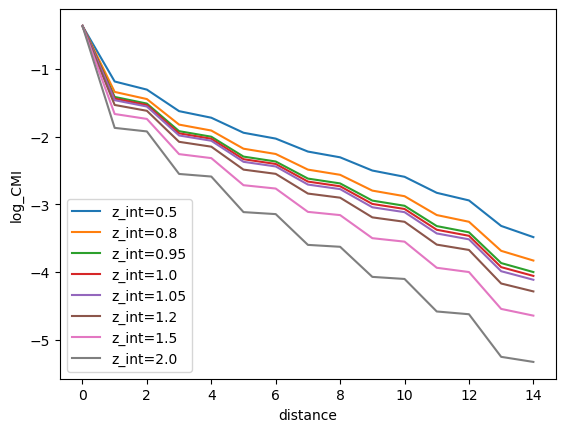

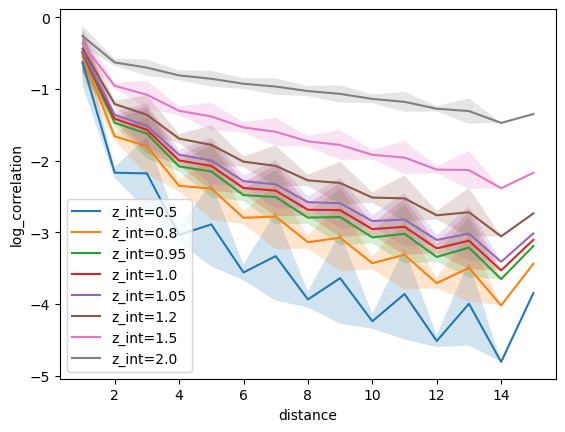

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


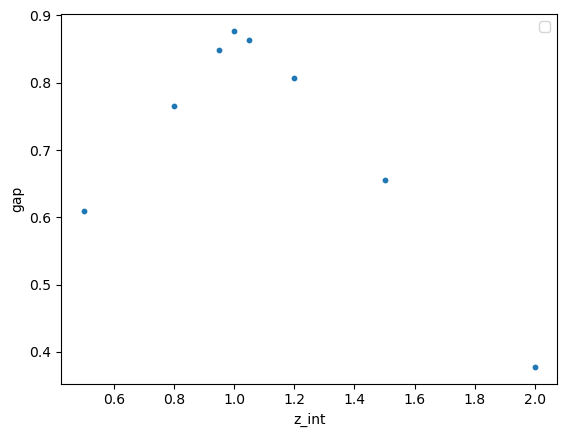

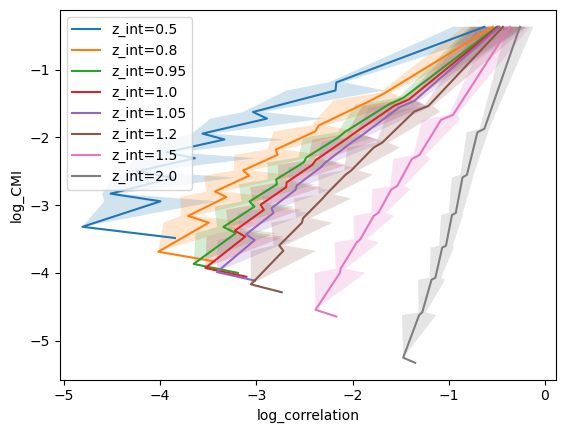

<Figure size 640x480 with 0 Axes>

In [27]:
for i in delta:
    plt.plot(np.log(cmi[i]), label="z_int="+str(i))
plt.xlabel("distance")
plt.ylabel("log_CMI")
plt.legend()
plt.savefig("figure/1DXXZ/cmi_1DXXZ_L"+str(L)+"_zint_"+str(z_int)+"periodic_"+str(periodic)+".png")
plt.show()
plt.clf()

for i in delta:
    plt.plot(np.arange(len(mean_corr[i])-1)+1, np.log(mean_corr[i][1:]), label="z_int="+str(i))
    if periodic == False:
        plt.fill_between(np.arange(len(mean_corr[i])-1)+1 ,np.log(mean_corr[i][1:]) - 1/mean_corr[i][1:]*np.sqrt(var_corr[i][1:]) , np.log(mean_corr[i][1:]) + 1/mean_corr[i][1:]*np.sqrt(var_corr[i][1:]), alpha=0.2)
plt.xlabel("distance")
plt.ylabel("log_correlation")
plt.legend()
plt.savefig("figure/1DXXZ/correlation_1DXXZ_L"+str(L)+"_zint_"+str(z_int)+"periodic_"+str(periodic)+".png")
plt.show()
plt.clf()

delta_ = [delta[i] for i in range(len(delta))]
plt.scatter(delta_, gap.values(), s=10)
plt.xlabel("z_int")
plt.ylabel("gap")
plt.legend()
plt.savefig("figure/1DXXZ/gap_1DXXZ_L"+str(L)+"_zint_"+str(z_int)+"periodic_"+str(periodic)+".png")
plt.show()
plt.clf()

for i in delta:
    plt.plot(np.log(mean_corr[i][1:]), np.log(cmi[i]), label="z_int="+str(i))
    if periodic == False:
        plt.fill_betweenx(np.log(cmi[i]), np.log(mean_corr[i][1:]) - 1/mean_corr[i][1:]*np.sqrt(var_corr[i][1:]) , np.log(mean_corr[i][1:]) + 1/mean_corr[i][1:]*np.sqrt(var_corr[i][1:]), alpha=0.2)
plt.xlabel("log_correlation")
plt.ylabel("log_CMI")
plt.legend()
plt.savefig("figure/1DXXZ/correlation_cmi_1DXXZ_L"+str(L)+"_zint_"+str(z_int)+"periodic_"+str(periodic)+".png")
plt.show()
plt.clf()


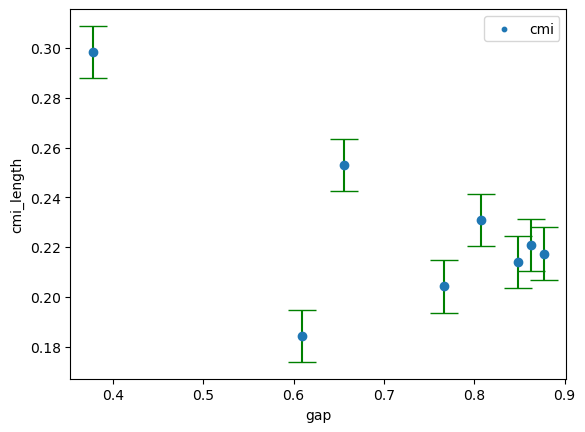

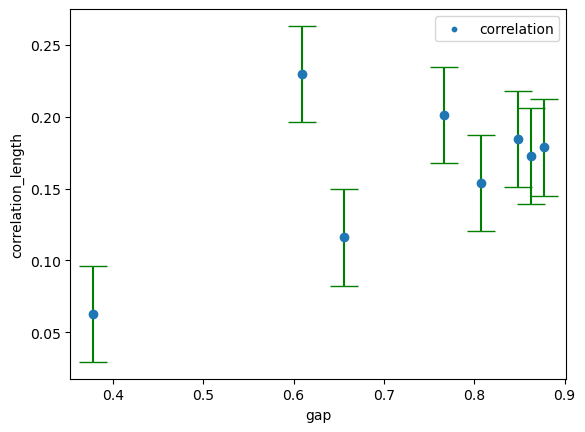

<Figure size 640x480 with 0 Axes>

In [25]:
gap_list = []
for i in delta:
    gap_list.append(gap[i])

plt.scatter(gap_list, cmi_length, label="cmi", s=10)
plt.errorbar(gap_list, cmi_length, yerr=err_cmi_length[:][0], fmt='o', ecolor='g', capthick=1, capsize=10)
plt.xlabel("gap")
plt.ylabel("cmi_length")
plt.legend()
plt.savefig("figure/1DXXZ/cmi_length_gap_1DXXZ_L"+str(L)+"_zint_"+str(z_int)+"periodic_"+str(periodic)+".png")
plt.show()
plt.clf()

plt.scatter(gap_list, corre_length, label="correlation", s=10)
plt.errorbar(gap_list, corre_length, yerr=err_corre_length[:][0], fmt='o', ecolor='g', capthick=1, capsize=10)
plt.xlabel("gap")
plt.ylabel("correlation_length")
plt.legend()
plt.savefig("figure/1DXXZ/correlation_length_gap_1DXXZ_L"+str(L)+"_zint_"+str(z_int)+"periodic_"+str(periodic)+".png")
plt.show()
plt.clf()

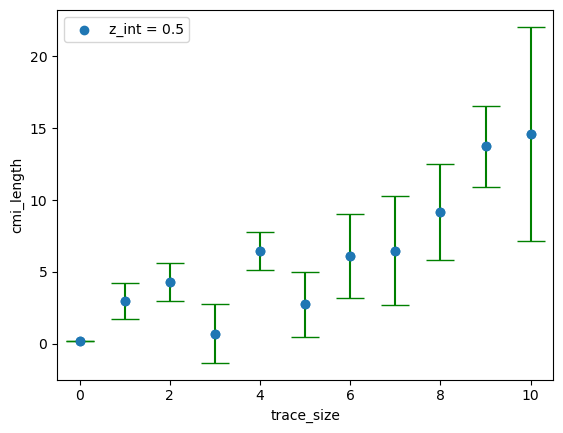

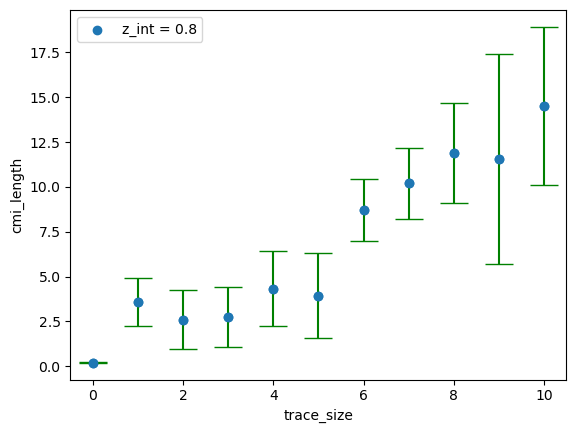

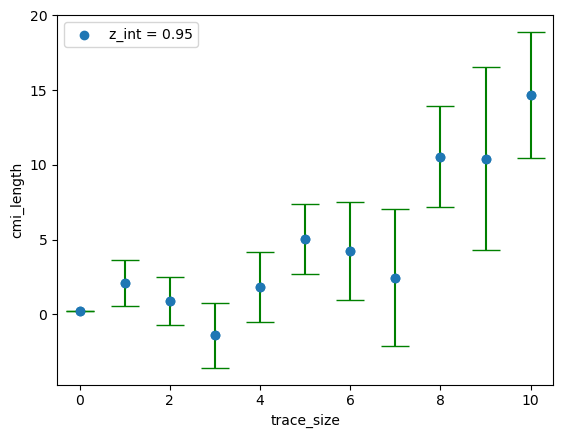

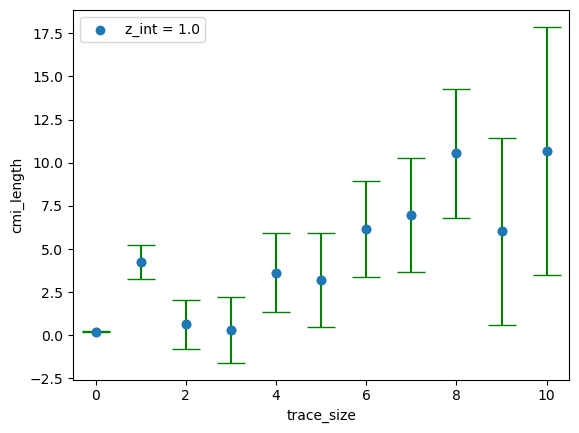

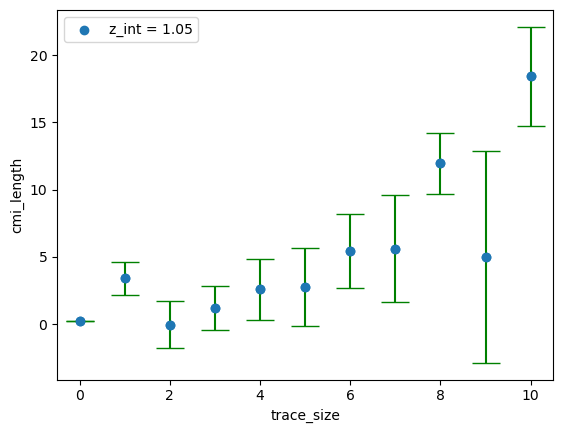

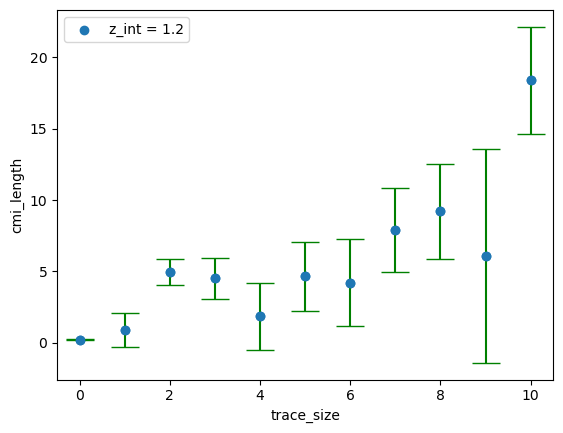

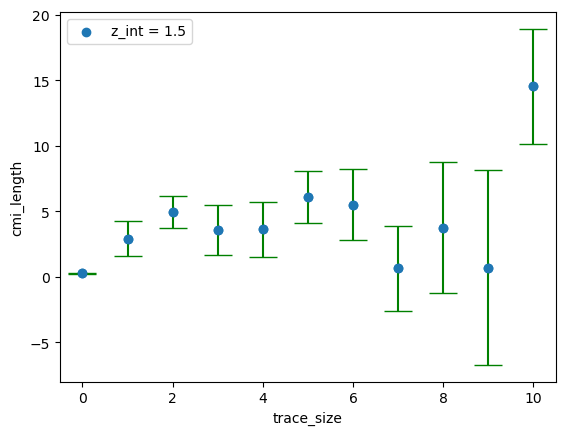

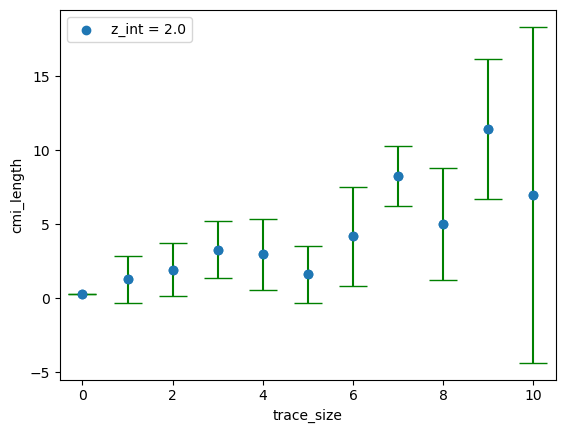

<Figure size 640x480 with 0 Axes>

In [26]:
for i in range(len(delta)):
    plt.scatter(np.arange(len(cmi_length_traceout[i])), cmi_length_traceout[i], label="z_int = "+str(delta[i]))
    plt.errorbar(np.arange(len(cmi_length_traceout[i])), cmi_length_traceout[i], yerr=np.array(err_cmi_length_traceout[i]).ravel(), fmt='o', ecolor='g', capthick=1, capsize=10)
    plt.xlabel("trace_size")
    plt.ylabel("cmi_length")
    plt.legend()
    plt.savefig("figure/1DXXZ/traceout/cmi_length_traceout_1DXXZ_L"+str(L)+"_zint_"+str(delta[i])+"periodic_"+str(periodic)+".png")
    plt.show()
    plt.clf()